# Task 3

# Imports

In [1]:
import json
import numpy as np
import pandas as pd
from joblib import dump, load

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import plotly.express as px

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16, 'axes.labelweight': 'bold', 'figure.figsize': (8,6)})

from statsmodels.tsa.api import seasonal_decompose
import matplotlib as mpl

import joblib

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-9m1n8vuo because the default path (/home/jupyter-student34/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Part 1:

Recall as a final goal of this project. We want to build and deploy ensemble machine learning models in the cloud, where features are outputs of different climate models and the target is the actual rainfall observation. In this milestone, you'll actually build these ensemble machine learning models in the cloud.  

**Your tasks:**

1. Read the data CSV from your s3 bucket. 
2. Drop rows with nans. 
3. Split the data into train (80%) and test (20%) portions with `random_state=123`. 
4. Carry out EDA of your choice on the train split. 
5. Train ensemble machine learning model using `RandomForestRegressor` and evaluate with metric of your choice (e.g., `RMSE`) by considering `Observed` as the target column. 
6. Discuss your results. Are you getting better results with ensemble models compared to the individual climate models? 

> Recall that individual columns in the data are predictions of different climate models. 

### Step 1: Read data

In [2]:
## You could download it from your bucket, or you can use the file that I have in my bucket. 
## You should be able to access it from my bucket using your key and secret
# aws_credentials ={"key": "","secret": ""} 

# Credential is stored in a file to avoid accidential commit
f = open("keys.txt", "r")
aws_credentials = json.loads(f.read())
df = pd.read_csv("s3://mds-s3-student34/output/ml_data_SYD.csv", index_col=0, parse_dates=True, storage_options=aws_credentials)

### Step 2: Drop rows with nans

In [3]:
df = df.dropna()

### Step 3: Split data

In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123, shuffle=False) # we are dealing with timeseries hence avoiding shuffling the data when splitting, although it should not matter much in this case

### Step 4: EDA

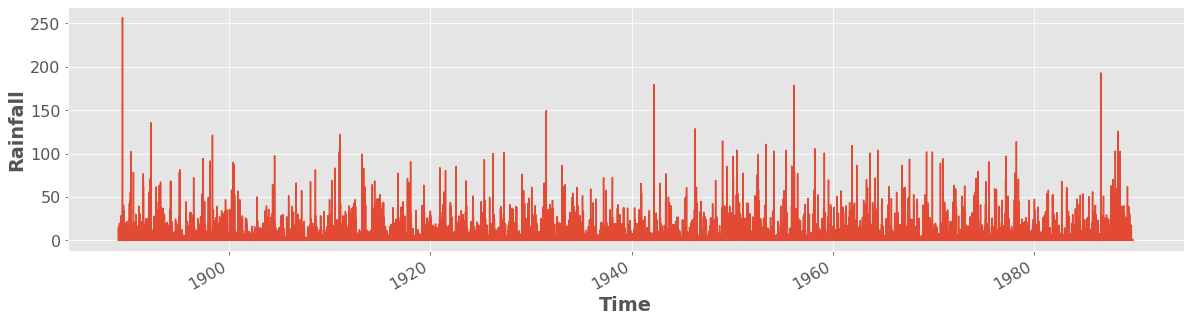

In [5]:
# EDA
train_df["Observed"].plot.line(xlabel="Time", ylabel="Rainfall", legend=False, figsize=(20,5));

<AxesSubplot:xlabel='time'>

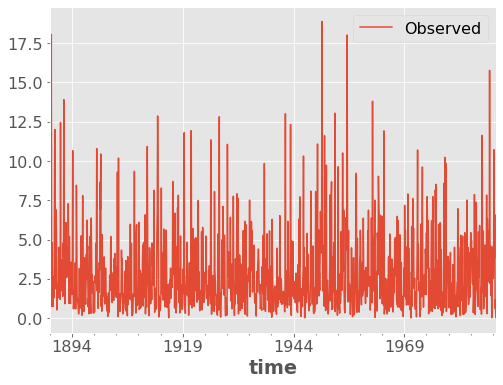

In [6]:
# resample the data into months to have better view of trend and seasonality
monthly_data = train_df[["Observed"]].resample("1M").mean()
monthly_data.index.fred="M"
monthly_data.plot()

In [7]:
# decompose the timeseries into trend and seasonality
model = seasonal_decompose(monthly_data[["Observed"]], model="additive", period=12) 

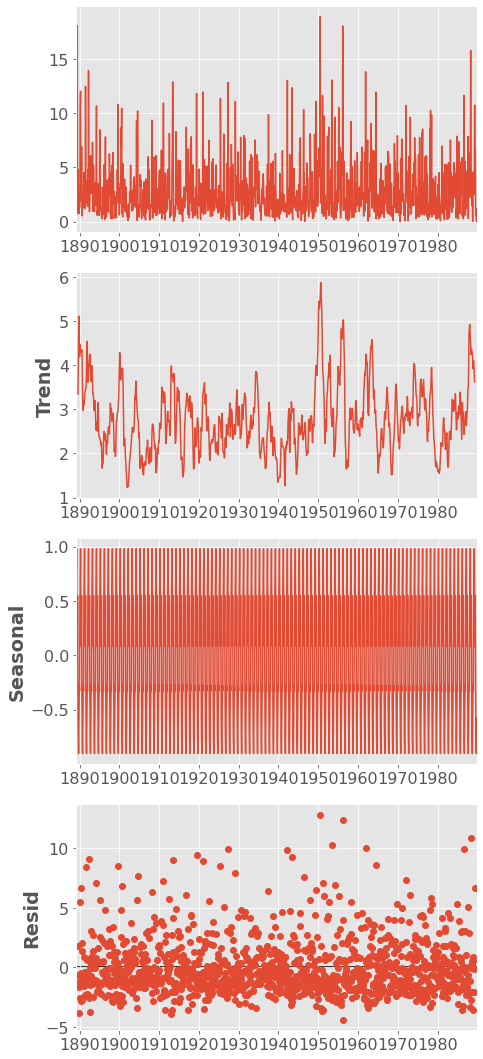

In [8]:
with mpl.rc_context():  
    mpl.rc("figure", figsize=(7, 15))
    model.plot()
    plt.tight_layout()

In [9]:
train_df.describe()

,ACCESS-CM2,ACCESS-ESM1-5,AWI-ESM-1-1-LR,BCC-CSM2-MR,BCC-ESM1,CMCC-CM2-HR4,CMCC-CM2-SR5,CMCC-ESM2,CanESM5,EC-Earth3-Veg-LR,...,MPI-ESM-1-2-HAM,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NESM3,NorESM2-LM,NorESM2-MM,SAM0-UNICON,TaiESM1,Observed
count,36791.000000,36791.000000,3.679100e+04,3.679100e+04,3.679100e+04,36791.000000,3.679100e+04,3.679100e+04,36791.000000,3.679100e+04,...,3.679100e+04,3.679100e+04,3.679100e+04,3.679100e+04,3.679100e+04,36791.000000,36791.000000,3.679100e+04,3.679100e+04,36791.000000
mean,2.418944,2.896285,3.664706e+00,2.211732e+00,2.767789e+00,3.101337,3.595210e+00,3.498250e+00,2.966061,2.597035e+00,...,3.212287e+00,1.322584e+00,2.079747e+00,1.491225e+00,1.722461e+00,2.445703,2.838375,3.319782e+00,3.441402e+00,2.777732
std,6.781286,6.879413,7.214366e+00,6.544580e+00,6.010654e+00,6.500920,7.387164e+00,7.078336e+00,7.024007,5.798388e+00,...,6.922027e+00,4.920043e+00,5.407070e+00,4.838441e+00,4.845465e+00,5.808536,6.980070,7.882558e+00,7.571911e+00,8.284286
min,0.000000,0.000000,9.161142e-14,4.370610e-24,1.107181e-24,0.000000,-4.503054e-17,-3.186177e-19,0.000000,-9.934637e-19,...,3.315622e-13,1.088608e-13,9.204019e-14,9.479186e-33,1.429162e-13,0.000000,0.000000,-3.604673e-17,-2.148475e-14,0.000000
25%,0.054225,0.021811,2.585608e-02,4.033173e-04,2.657978e-03,0.138223,8.795451e-02,9.175020e-02,0.023616,1.287460e-02,...,1.408160e-04,1.271249e-13,1.357380e-13,5.740648e-05,1.852582e-13,0.005352,0.009713,3.741288e-02,4.905343e-02,0.008818
50%,0.190864,0.491260,5.759248e-01,9.092876e-02,3.053905e-01,0.633034,8.247926e-01,8.422411e-01,0.368521,4.410744e-01,...,2.130571e-01,1.659617e-03,1.172821e-01,3.069196e-02,5.106960e-02,0.168483,0.248595,6.406431e-01,6.675421e-01,0.182341
75%,1.418816,2.388891,3.547054e+00,1.332665e+00,2.526573e+00,3.185832,3.742353e+00,3.615350e+00,2.682899,2.351880e+00,...,2.703393e+00,3.560368e-01,1.218444e+00,6.646839e-01,7.905046e-01,1.822219,2.428031,3.206986e+00,3.211678e+00,1.648488
max,149.967634,157.605713,8.946575e+01,1.344652e+02,8.713472e+01,109.098855,1.401478e+02,1.375916e+02,135.569753,1.342262e+02,...,9.306766e+01,1.038506e+02,8.005998e+01,1.051568e+02,8.045783e+01,114.898109,163.164524,1.549718e+02,1.166465e+02,256.455080


**Highlights:**
- There is seasonality in the timeseries for every 12 months, which makes sense
- There is no trend detected in the data
- The prediction varies considerably among models

### Step 5

In [10]:
X_train, y_train = train_df.drop(columns="Observed"), train_df["Observed"]
X_test, y_test = test_df.drop(columns="Observed"), test_df["Observed"]

In [11]:
# Train ensemble ML model using `RandomForestRegressor`
import os

test_mode = False # set test_mode to True to avoid re-training the model during testing stage
if (test_mode and os.path.exists("first_model.joblib")):
    model = joblib.load("first_model.joblib")
else:
    model = RandomForestRegressor(random_state=123)
    model.fit(X_train, y_train)
    dump(model, "first_model.joblib") # save model so that we can reload during testing

In [12]:
# Evaluate
print(f"Train RMSE: {mean_squared_error(y_train, model.predict(X_train), squared=False):.2f}")
print(f" Test RMSE: {mean_squared_error(y_test, model.predict(X_test), squared=False):.2f}")

Train RMSE: 3.24
 Test RMSE: 8.08


### Step 6

In [13]:
# create a column to store the prediction of the ensemble model
test_df = test_df.assign(Ensemble = model.predict(X_test))
test_df.head()

,ACCESS-CM2,ACCESS-ESM1-5,AWI-ESM-1-1-LR,BCC-CSM2-MR,BCC-ESM1,CMCC-CM2-HR4,CMCC-CM2-SR5,CMCC-ESM2,CanESM5,EC-Earth3-Veg-LR,...,MPI-ESM1-2-HR,MPI-ESM1-2-LR,MRI-ESM2-0,NESM3,NorESM2-LM,NorESM2-MM,SAM0-UNICON,TaiESM1,Observed,Ensemble
time,,,,,,,,,,,,,,,,,,,,,
1989-10-20,0.219339,0.001521,1.117539e-13,4.180110e-01,4.989895,1.161463,0.135131,2.092660e+00,0.181639,-4.895401e-20,...,1.247387e-13,3.552636e+00,4.248013e-18,3.485942e-02,0.068946,0.125749,0.033357,1.895946,0.700673,1.083308
1989-10-21,0.055218,1.819894,1.566437e+00,1.269076e-08,0.915879,0.676991,0.008308,9.136886e-01,0.956078,-7.228011e-20,...,1.292251e-13,2.833620e-01,4.177801e-01,1.130954e-07,0.096040,0.078274,1.824664,0.973379,0.341154,1.034965
1989-10-22,0.013428,0.588268,1.072806e-13,2.165644e-02,7.124331,2.456995,3.445798,7.479689e-01,0.009526,1.115799e-02,...,2.089910e-01,1.022562e-13,2.155149e+00,1.850952e-08,8.172772,0.030886,2.806819,0.000277,0.009556,3.002688
1989-10-23,1.452529,0.561795,5.502284e-01,5.186514e+01,3.420923,4.374916,21.353840,1.860805e-13,0.081571,6.265640e-02,...,3.488716e-02,1.122544e-13,3.248625e+00,1.601959e-13,1.218779,1.615460,0.107130,0.035640,0.597030,6.262447
1989-10-24,0.148280,0.491199,3.590355e-01,2.572335e+00,5.143028,7.720900,4.057471,3.618783e-02,0.003499,2.167654e+00,...,1.223828e-13,1.107384e-13,4.513370e+00,2.978377e-02,1.944571,1.315995,0.504264,0.836204,2.249953,2.353131


In [14]:
# visualize the predictions of all models compared to the observed data
# there are too many models to have a clear plot hence disabling this code
# r_test_df = test_df.reset_index()
# result_df = pd.melt(r_test_df, value_vars = r_test_df.columns[1:], 
#                     var_name="Model", value_name="Rainfall", id_vars = ["time"]).set_index("time")
# px.line(result_df, y="Rainfall", color="Model", width=800)

In [15]:
# create a data frame to store MSE of all models compared to the observed data
mse_results = {}
cols = test_df.columns.to_list() # get the list of all model names
cols.remove("Observed")
for c in cols:
    mse_results[c] = mean_squared_error(test_df["Observed"], test_df[c], squared=False) # store MSE of the current model to the dictionary
mse_results_df = pd.DataFrame.from_dict(mse_results, orient="index", columns=["MSE"]).sort_values(by="MSE")
mse_results_df

,MSE
Ensemble,8.076678
FGOALS-g3,8.825898
KIOST-ESM,8.929471
MPI-ESM1-2-HR,9.136171
NESM3,9.238419
MPI-ESM1-2-LR,9.358796
GFDL-CM4,9.460040
MRI-ESM2-0,9.494019
EC-Earth3-Veg-LR,9.560820
NorESM2-LM,9.801393


> results discussion -  Are you getting better results with ensemble models compared to the individual climate models?

**Comments**: Ensemble machine learning model using RandomForestRegressor generates better predictions in terms of lower mean squared errors in comparison to the indivitual climate models.

## Part 2:

### Preparation for deploying model next week

#### Already completed task 4 from the milestone3 before coming here

We’ve found ```n_estimators=100, max_depth=5``` to be the best hyperparameter settings with MLlib (from the task 4 from milestone3), here we then use the same hyperparameters to train a scikit-learn model. 

In [16]:
model = RandomForestRegressor(n_estimators=100, max_depth=5) 
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5)

In [17]:
print(f"Train RMSE: {mean_squared_error(y_train, model.predict(X_train), squared=False):.2f}")
print(f" Test RMSE: {mean_squared_error(y_test, model.predict(X_test), squared=False):.2f}")

Train RMSE: 8.09
 Test RMSE: 7.81


In [18]:
# ready to deploy
dump(model, "model.joblib")

['model.joblib']

***Upload model.joblib to s3. You choose how you want to upload it.***

In [19]:
# model.joblib